Data Preprocessing

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

print(os.cpu_count())

96


In [3]:
!pip install netCDF4 h5netcdf xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.2 MB/s eta 0:00:00


In [4]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/dataset-carbon-rep-monthly_multi-vars_179.88W-179.88E_88.12S-89.88N_2011-09-01-2022-12-01.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
ocs_df = xr_dataset.to_dataframe().reset_index()

In [5]:
import pandas as pd
dic = ocs_df[['tco2', 'latitude', 'longitude', 'time']]
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [6]:
dic['yr'] = dic['time'].dt.year
dic['mn'] = dic['time'].dt.month
dic['month'] = (dic['yr'] - 2011) * 12 + dic['mn'] - 9
dic['longitude'] = (dic['longitude'] + 360) % 360
dic.drop(columns=['yr', 'mn'], inplace=True)

<ipython-input-6-f19c288c5524>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dic['yr'] = dic['time'].dt.year
<ipython-input-6-f19c288c5524>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dic['mn'] = dic['time'].dt.month
<ipython-input-6-f19c288c5524>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [7]:
print(dic.shape)
print(satellite_data.shape)

(139633920, 5)
(155520000, 10)


In [8]:
dic = dic.dropna()
satellite_data = satellite_data.dropna()

In [9]:
print(dic.shape)
print(satellite_data.shape)

(79617884, 5)
(66907461, 10)


In [10]:
# when merging, remember that longitude ranges from 0-360 instead of smth else
merged_dic_df = pd.merge(dic, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [11]:
import numpy as np
merged_dic_df['mn'] = merged_dic_df['month'] % 12
merged_dic_df['cmon'] = np.cos(np.deg2rad(merged_dic_df['mn']))
merged_dic_df['smon'] = np.sin(np.deg2rad(merged_dic_df['mn']))
merged_dic_df['clon'] = np.cos(np.deg2rad(merged_dic_df['longitude']))
merged_dic_df['slon'] = np.sin(np.deg2rad(merged_dic_df['longitude']))
merged_dic_df['pic/poc'] = merged_dic_df['pic']/merged_dic_df['poc']
merged_dic_df['logchla'] = np.log(merged_dic_df['chlor_a'] + 1e-5)
merged_dic_df['windspeed'] = np.sqrt(merged_dic_df['u_wind'] ** 2 + merged_dic_df['v_wind'] ** 2)
merged_dic_df['winddir'] = (np.degrees(np.arctan2(merged_dic_df['u_wind'] + 1e-5, merged_dic_df['u_wind'] + 1e-5)) + 360) % 360

In [12]:
merged_dic_df

,tco2,latitude,longitude,time,month,sst,chlor_a,sss,poc,pic,...,v_wind,mn,cmon,smon,clon,slon,pic/poc,logchla,windspeed,winddir
0,2165.161133,-64.625,249.375,2011-09-01,0,0.440000,0.119880,33.823605,59.799805,0.000360,...,3.067366,0,1.00000,0.000000,-0.352250,-0.935906,6.020039e-06,-2.121184,10.800000,45.0
1,2160.100098,-64.375,250.125,2011-09-01,0,0.375000,0.127854,33.787605,51.399902,0.000144,...,2.203864,0,1.00000,0.000000,-0.339969,-0.940437,2.801511e-06,-2.056788,10.599999,45.0
2,2169.980713,-64.125,246.875,2011-09-01,0,0.235000,0.107158,33.830870,67.199710,0.000774,...,1.087096,0,1.00000,0.000000,-0.392738,-0.919650,1.151785e-05,-2.233360,10.400000,45.0
3,2164.440918,-64.125,255.625,2011-09-01,0,-0.630000,0.103240,33.833477,52.199707,0.000328,...,2.037535,0,1.00000,0.000000,-0.248267,-0.968692,6.283501e-06,-2.270597,9.800000,45.0
4,2164.962646,-64.125,255.875,2011-09-01,0,-0.830000,0.113233,33.840218,49.000000,0.000190,...,2.037535,0,1.00000,0.000000,-0.244038,-0.969766,3.877495e-06,-2.178218,9.800000,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60517952,2118.067627,47.125,356.375,2022-12-01,135,13.875000,0.795078,35.295600,154.399900,0.000010,...,9.786570,3,0.99863,0.052336,0.997999,-0.063226,6.475833e-08,-0.229303,9.800001,45.0
60517953,2120.963135,47.375,355.875,2022-12-01,135,13.395000,0.949561,35.298150,169.600100,0.000010,...,9.986296,3,0.99863,0.052336,0.997409,-0.071933,5.895444e-08,-0.051745,10.000001,225.0
60517954,2121.536377,47.375,356.125,2022-12-01,135,13.759999,0.990445,35.302296,170.000000,0.000042,...,9.996573,3,0.99863,0.052336,0.997714,-0.067580,2.470525e-07,-0.009591,10.000000,225.0
60517955,2123.974365,47.375,356.375,2022-12-01,135,13.835000,1.030679,35.301792,195.799800,0.000926,...,10.186021,3,0.99863,0.052336,0.997999,-0.063226,4.729297e-06,0.030227,10.200000,225.0


In [13]:
test = merged_dic_df[merged_dic_df['time'].dt.year >= 2021]
validation = merged_dic_df[(merged_dic_df['time'].dt.year >= 2019) & (merged_dic_df['time'].dt.year < 2021)]
merged_dic_df = merged_dic_df[merged_dic_df['time'].dt.year < 2019]

In [ ]:
print(test.shape)
print(validation.shape)
print(merged_dic_df.shape)

(10598925, 21)
(10669288, 21)
(39249744, 21)


Feature Selection

In [ ]:
X = merged_dic_df[['latitude', 'longitude', 'sst', 'chlor_a', 'sss', 'poc', 'pic', 'u_wind', 'v_wind', 'cmon', 'smon', 'clon', 'slon', 'mn', 'pic/poc', 'logchla', 'windspeed', 'winddir']] # test with pic/poc, clon, slon, as well as month
y = merged_dic_df['tco2']

In [ ]:
!pip install xgboost

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Replace X and y with your actual data variables if different
# X = pd.DataFrame(...)  # Your features: Latitude, Longitude, SST, and SSS
# y = pd.Series(...)     # Your target variable: TA

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
X_train.shape

(31399795, 18)

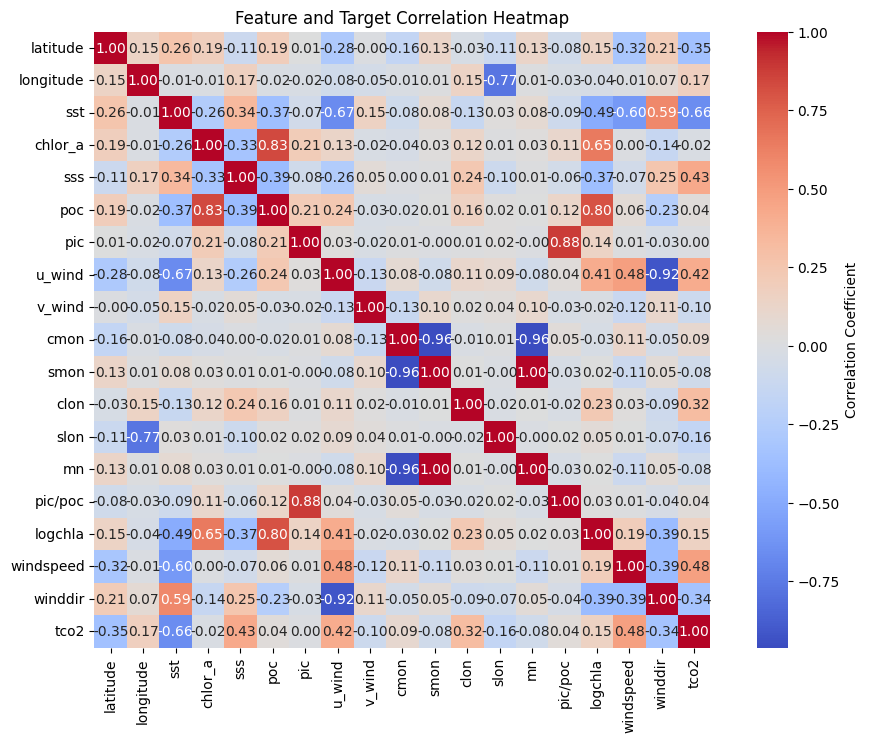

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and targets into a single DataFrame for correlation calculation
data_combined = pd.concat([X, y], axis=1)

# Calculate correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature and Target Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix['tco2']

,tco2
latitude,-0.352970
longitude,0.173520
sst,-0.662478
chlor_a,-0.019061
sss,0.425752
poc,0.035013
pic,0.000403
u_wind,0.415330
v_wind,-0.102617
cmon,0.092985


In [ ]:
sample_indices = X.sample(frac=0.05, random_state=42).index
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

# Basic Random Forest model for feature selection
rf = RandomForestRegressor(
    n_estimators=100,         # Enough trees for stable feature importance
    max_depth=15,             # Limit depth to avoid overfitting
    max_features='log2',      # Introduces randomness in splits, suitable for regression
    random_state=42,
    n_jobs=-1
)

rf.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=15, max_features='log2', n_jobs=-1,
                      random_state=42)

In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importances)

      feature  importance
2         sst    0.262765
4         sss    0.239261
0    latitude    0.175121
7      u_wind    0.061265
1   longitude    0.060251
11       clon    0.059968
12       slon    0.037127
16  windspeed    0.030802
17    winddir    0.014521
5         poc    0.012280
15    logchla    0.011331
3     chlor_a    0.011071
10       smon    0.005756
13         mn    0.005538
9        cmon    0.005402
8      v_wind    0.004343
6         pic    0.002830
14    pic/poc    0.000366


sss, latitude, clon, slon, sst, logchla

In [ ]:
X_train = merged_dic_df[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y_train = merged_dic_df['tco2']
X_val = validation[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y_val = validation['tco2']
X_test = test[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y_test = test['tco2']

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
sample_indices = X_train.sample(frac=0.05, random_state=42).index
X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]

In [ ]:
!pip install geopandas shapely cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.7 MB/s eta 0:00:00


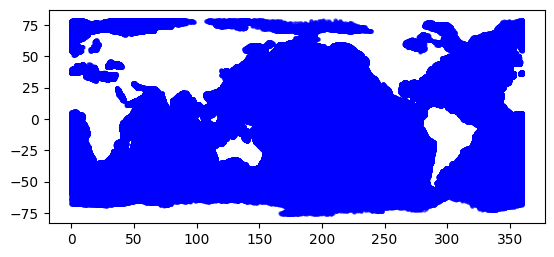

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

latitudes = X_sample['latitude']
longitudes = X_sample['longitude']

gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(longitudes, latitudes)])

gdf.plot(marker='o', color='blue', markersize=5, alpha=0.5)
plt.show()

In [ ]:
!pip install tqdm

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np

# Define the pipeline and parameter grid
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, verbose=0))
])

param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Initialize variables to track the best model and score
best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_rf.set_params(**params)

    pipeline_rf.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_rf, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_rf, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_rf

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")

Grid Search Progress:   0%|          | 0/24 [00:00<?, ?combination/s]

Training MSE, R2: 
68.76937208732964 0.9878539968361955


Grid Search Progress:   4%|▍         | 1/24 [01:26<33:05, 86.31s/combination, Best MSE=146]

Validation MSE, R2: 
145.8341264081521 0.9748634226142431
Training MSE, R2: 
68.34046746945573 0.9879297496995348


Grid Search Progress:   8%|▊         | 2/24 [03:44<42:47, 116.68s/combination, Best MSE=145]

Validation MSE, R2: 
145.34389975460275 0.9749479201219047
Training MSE, R2: 
69.56773425133905 0.9877129906138672


Grid Search Progress:  12%|█▎        | 3/24 [05:02<34:41, 99.13s/combination, Best MSE=145] 

Validation MSE, R2: 
145.60599001221303 0.9749027451535709
Training MSE, R2: 
69.1914566291912 0.9877794485303837


Grid Search Progress:  17%|█▋        | 4/24 [07:04<36:01, 108.08s/combination, Best MSE=145]

Validation MSE, R2: 
145.1499564404946 0.9749813489992436
Training MSE, R2: 
69.6785464168213 0.9876934190390267


Grid Search Progress:  21%|██        | 5/24 [08:21<30:41, 96.93s/combination, Best MSE=145] 

Validation MSE, R2: 
145.43609682291697 0.9749320286512353
Training MSE, R2: 
69.323015131713 0.9877562127505685


Grid Search Progress:  25%|██▌       | 6/24 [10:22<31:33, 105.22s/combination, Best MSE=145]

Validation MSE, R2: 
145.03568389763126 0.9750010454906445
Training MSE, R2: 
70.00046409357834 0.9876365621418108


Grid Search Progress:  29%|██▉       | 7/24 [11:37<26:59, 95.25s/combination, Best MSE=145] 

Validation MSE, R2: 
145.2886782061069 0.9749574383379856
Training MSE, R2: 
69.65928882086658 0.9876968203034893


Grid Search Progress:  33%|███▎      | 8/24 [13:31<26:58, 101.14s/combination, Best MSE=145]

Validation MSE, R2: 
144.93581973060924 0.9750182584943785
Training MSE, R2: 
238.87381895580705 0.9578102566197216


Grid Search Progress:  38%|███▊      | 9/24 [14:13<20:40, 82.71s/combination, Best MSE=145] 

Validation MSE, R2: 
302.6297480065601 0.9478374762659545
Training MSE, R2: 
238.7091847709847 0.9578393342057026


Grid Search Progress:  42%|████▏     | 10/24 [15:20<18:09, 77.79s/combination, Best MSE=145]

Validation MSE, R2: 
302.4360556775505 0.9478708618824565
Training MSE, R2: 
238.88735282870866 0.957807866275618


Grid Search Progress:  46%|████▌     | 11/24 [16:01<14:26, 66.63s/combination, Best MSE=145]

Validation MSE, R2: 
302.6006980508385 0.9478424834373076
Training MSE, R2: 
238.7174102643687 0.9578378814242442


Grid Search Progress:  50%|█████     | 12/24 [17:09<13:22, 66.91s/combination, Best MSE=145]

Validation MSE, R2: 
302.41192816125823 0.947875020601649
Training MSE, R2: 
238.88762737339766 0.957807817785708


Grid Search Progress:  54%|█████▍    | 13/24 [17:50<10:50, 59.11s/combination, Best MSE=145]

Validation MSE, R2: 
302.699700603212 0.9478254189450627
Training MSE, R2: 
238.7175492109545 0.9578378568835858


Grid Search Progress:  58%|█████▊    | 14/24 [18:57<10:15, 61.54s/combination, Best MSE=145]

Validation MSE, R2: 
302.4788248795232 0.9478634900046828
Training MSE, R2: 
238.89272702152692 0.9578069170890688


Grid Search Progress:  62%|██████▎   | 15/24 [19:38<08:18, 55.38s/combination, Best MSE=145]

Validation MSE, R2: 
302.6679694823102 0.9478308882532125
Training MSE, R2: 
238.71999548616807 0.9578374248239991


Grid Search Progress:  67%|██████▋   | 16/24 [20:44<07:49, 58.64s/combination, Best MSE=145]

Validation MSE, R2: 
302.47016336022557 0.9478649829402218
Training MSE, R2: 
77.13805303965289 0.9863759256798279


Grid Search Progress:  71%|███████   | 17/24 [21:44<06:51, 58.85s/combination, Best MSE=145]

Validation MSE, R2: 
145.59241516397748 0.9749050849709482
Training MSE, R2: 
76.90587928299718 0.9864169320624266


Grid Search Progress:  75%|███████▌  | 18/24 [23:18<06:57, 69.65s/combination, Best MSE=145]

Validation MSE, R2: 
145.18378639672022 0.9749755179270964
Training MSE, R2: 
77.572789175824 0.9862991428574015


Grid Search Progress:  79%|███████▉  | 19/24 [24:18<05:32, 66.54s/combination, Best MSE=145]

Validation MSE, R2: 
145.6494519890739 0.9748952538662323
Training MSE, R2: 
77.3501743059204 0.9863384609554455


Grid Search Progress:  83%|████████▎ | 20/24 [25:53<05:00, 75.21s/combination, Best MSE=145]

Validation MSE, R2: 
145.35430203064686 0.9749461271422831
Training MSE, R2: 
77.4578410158692 0.9863194449289794


Grid Search Progress:  88%|████████▊ | 21/24 [26:53<03:31, 70.54s/combination, Best MSE=145]

Validation MSE, R2: 
145.46680685037236 0.9749267353430044
Training MSE, R2: 
77.25486346031046 0.9863552946969382


Grid Search Progress:  92%|█████████▏| 22/24 [28:28<02:35, 77.98s/combination, Best MSE=145]

Validation MSE, R2: 
145.17678007752116 0.9749767255654529
Training MSE, R2: 
77.62729045567316 0.9862895168756979


Grid Search Progress:  96%|█████████▌| 23/24 [29:28<01:12, 72.48s/combination, Best MSE=145]

Validation MSE, R2: 
145.44309557251546 0.9749308223176066
Training MSE, R2: 
77.42293310386484 0.9863256103424007


Grid Search Progress: 100%|██████████| 24/24 [31:06<00:00, 77.78s/combination, Best MSE=145]

Validation MSE, R2: 
145.17377345540584 0.9749772437993623
Best MSE: 


In [ ]:
best_params={
  'rf__max_depth': 20,
  'rf__min_samples_leaf': 2,
  'rf__min_samples_split': 5,
  'rf__n_estimators': 200
}


In [ ]:
# Fit the best model on the full training data and evaluate on the test set
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=67, verbose=1))
])
pipeline_rf.set_params(**best_params)
pipeline_rf.fit(X_train, y_train)
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_train, y_train)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_val, y_val)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_test, y_test)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:  8.3min
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed: 19.7min finished
[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   12.4s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   25.4s finished


rf - MSE: 58.9565, R²: 0.9896


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.4s finished


rf - MSE: 145.9887, R²: 0.9748


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.3s finished


rf - MSE: 185.9136, R²: 0.9672


In [ ]:
!pip install joblib

In [ ]:
import joblib
joblib.dump(pipeline_rf, '/content/drive/MyDrive/STS/rf_dic.joblib')

['/content/drive/MyDrive/STS/rf_dic.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

best_score = float('-inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_knn.set_params(**params)

    # Perform cross-validation and get the mean score
    scores = cross_val_score(pipeline_knn, X_sample, y_sample, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=3)
    mean_score = np.mean(scores)

    # Update the best model if the current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = pipeline_knn

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': -best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/6 [00:00<?, ?combination/s]

[CV] END ............................. score: (test=-123.979) total time=  25.2s
[CV] END ............................. score: (test=-124.880) total time=  30.6s
[CV] END ............................. score: (test=-122.595) total time=  31.5s
[CV] END ............................. score: (test=-121.530) total time=  30.7s


Grid Search Progress:  17%|█▋        | 1/6 [02:29<12:25, 149.15s/combination, Best MSE=124]

[CV] END ............................. score: (test=-124.558) total time=  31.1s
[CV] END ............................. score: (test=-120.195) total time=  19.6s
[CV] END ............................. score: (test=-120.939) total time=  19.4s
[CV] END ............................. score: (test=-118.719) total time=  19.1s
[CV] END ............................. score: (test=-117.414) total time=  25.0s


Grid Search Progress:  33%|███▎      | 2/6 [04:17<08:19, 124.98s/combination, Best MSE=120]

[CV] END ............................. score: (test=-120.942) total time=  25.0s
[CV] END ............................. score: (test=-118.579) total time=  34.4s
[CV] END ............................. score: (test=-118.809) total time=  15.8s
[CV] END ............................. score: (test=-117.284) total time=  15.8s
[CV] END ............................. score: (test=-115.015) total time=  15.8s


Grid Search Progress:  50%|█████     | 3/6 [05:54<05:37, 112.55s/combination, Best MSE=118]

[CV] END ............................. score: (test=-119.268) total time=  16.0s
[CV] END ............................. score: (test=-113.225) total time=  31.0s
[CV] END ............................. score: (test=-113.389) total time=  31.4s
[CV] END ............................. score: (test=-111.923) total time=  30.6s
[CV] END ............................. score: (test=-109.540) total time=  31.0s


Grid Search Progress:  67%|██████▋   | 4/6 [08:30<04:18, 129.48s/combination, Best MSE=112]

[CV] END ............................. score: (test=-113.775) total time=  31.4s
[CV] END ............................. score: (test=-116.735) total time=  34.1s
[CV] END ............................. score: (test=-117.114) total time=  34.2s
[CV] END ............................. score: (test=-115.817) total time=  33.2s
[CV] END ............................. score: (test=-113.803) total time=  33.8s


Grid Search Progress:  83%|████████▎ | 5/6 [11:20<02:23, 143.96s/combination, Best MSE=112]

[CV] END ............................. score: (test=-118.065) total time=  34.4s
[CV] END ............................. score: (test=-110.666) total time=  29.3s
[CV] END ............................. score: (test=-111.116) total time=  29.0s
[CV] END ............................. score: (test=-109.744) total time=  28.3s
[CV] END ............................. score: (test=-107.385) total time=  28.8s


Grid Search Progress: 100%|██████████| 6/6 [13:44<00:00, 137.41s/combination, Best MSE=110]

[CV] END ............................. score: (test=-111.680) total time=  29.0s
Best MSE: 
-110.11808201059371


In [ ]:
best_params = {'knn__n_neighbors': 7, 'knn__weights': 'distance'}

In [ ]:
# Fit the best model on the full training data and evaluate on the test set
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])
pipeline_knn.set_params(**best_params)
pipeline_knn.fit(X_sample, y_sample)
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_sample, y_sample)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_val, y_val)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_test, y_test)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")

knn - MSE: 0.0000, R²: 1.0000
knn - MSE: 197.0861, R²: 0.9660
knn - MSE: 234.0104, R²: 0.9587


In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/knn_dic.joblib')

In [ ]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Evaluate
mse_lr, r2_lr = evaluate_model(pipeline_lr, X_test, y_test)
print(f"Linear Regression - MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

Linear Regression - MSE: 466.8552, R²: 0.9179


In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/lr_dic.joblib')

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'xgb__n_estimators': [200],             # Number of boosting rounds
    'xgb__max_depth': [3, 6, 9],                    # Maximum depth of a tree
    'xgb__learning_rate': [0.05, 0.1],           # Step size shrinkage
    'xgb__subsample': [0.8],                # Fraction of samples for each boosting round
    'xgb__colsample_bytree': [0.8, 1.0],         # Fraction of features used per tree
    'xgb__min_child_weight': [1, 5],             # Minimum sum of instance weight for leaf nodes
    'xgb__gamma': [0, 0.1],                      # Minimum loss reduction for partitioning
}

best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_xgb))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_xgb.set_params(**params)

    pipeline_xgb.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_xgb, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_xgb, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_xgb

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")

Grid Search Progress:   0%|          | 0/48 [00:00<?, ?combination/s]

Training MSE, R2: 
284.79782 0.9496991634368896


Grid Search Progress:   2%|▏         | 1/48 [00:11<09:00, 11.50s/combination, Best MSE=355]

Validation MSE, R2: 
355.404 0.9387410879135132
Training MSE, R2: 
284.79782 0.9496991634368896


Grid Search Progress:   4%|▍         | 2/48 [00:23<09:09, 11.96s/combination, Best MSE=355]

Validation MSE, R2: 
355.404 0.9387410879135132
Training MSE, R2: 
143.59276 0.9746387600898743


Grid Search Progress:   6%|▋         | 3/48 [00:40<10:33, 14.07s/combination, Best MSE=198]

Validation MSE, R2: 
197.90877 0.9658876061439514
Training MSE, R2: 
144.60754 0.9744595289230347


Grid Search Progress:   8%|▊         | 4/48 [00:57<11:19, 15.45s/combination, Best MSE=198]

Validation MSE, R2: 
199.08249 0.9656853079795837
Training MSE, R2: 
101.70687 0.9820365905761719


Grid Search Progress:  10%|█         | 5/48 [01:25<14:15, 19.89s/combination, Best MSE=156]

Validation MSE, R2: 
155.9754 0.9731154441833496
Training MSE, R2: 
101.925224 0.9819980263710022


Grid Search Progress:  12%|█▎        | 6/48 [02:00<17:33, 25.07s/combination, Best MSE=156]

Validation MSE, R2: 
156.02821 0.973106324672699
Training MSE, R2: 
232.87628 0.9588695168495178


Grid Search Progress:  15%|█▍        | 7/48 [02:09<13:29, 19.74s/combination, Best MSE=156]

Validation MSE, R2: 
299.64407 0.9483520984649658
Training MSE, R2: 
232.8765 0.9588695168495178


Grid Search Progress:  17%|█▋        | 8/48 [02:21<11:31, 17.28s/combination, Best MSE=156]

Validation MSE, R2: 
299.64175 0.9483525156974792
Training MSE, R2: 
124.5365 0.9780044555664062


Grid Search Progress:  19%|█▉        | 9/48 [02:37<11:01, 16.97s/combination, Best MSE=156]

Validation MSE, R2: 
174.85854 0.9698606729507446
Training MSE, R2: 
124.29338 0.9780473709106445


Grid Search Progress:  21%|██        | 10/48 [02:53<10:24, 16.45s/combination, Best MSE=156]

Validation MSE, R2: 
174.80682 0.9698695540428162
Training MSE, R2: 
95.19827 0.9831861257553101


Grid Search Progress:  23%|██▎       | 11/48 [03:13<10:56, 17.74s/combination, Best MSE=151]

Validation MSE, R2: 
150.8165 0.9740046262741089
Training MSE, R2: 
95.10076 0.9832033514976501


Grid Search Progress:  25%|██▌       | 12/48 [03:40<12:19, 20.53s/combination, Best MSE=150]

Validation MSE, R2: 
150.46817 0.9740646481513977
Training MSE, R2: 
284.79782 0.9496991634368896


Grid Search Progress:  27%|██▋       | 13/48 [03:50<10:03, 17.23s/combination, Best MSE=150]

Validation MSE, R2: 
355.404 0.9387410879135132
Training MSE, R2: 
284.79782 0.9496991634368896


Grid Search Progress:  29%|██▉       | 14/48 [04:00<08:28, 14.95s/combination, Best MSE=150]

Validation MSE, R2: 
355.404 0.9387410879135132
Training MSE, R2: 
143.59276 0.9746387600898743


Grid Search Progress:  31%|███▏      | 15/48 [04:18<08:47, 15.98s/combination, Best MSE=150]

Validation MSE, R2: 
197.90877 0.9658876061439514
Training MSE, R2: 
144.60754 0.9744595289230347


Grid Search Progress:  33%|███▎      | 16/48 [04:36<08:51, 16.61s/combination, Best MSE=150]

Validation MSE, R2: 
199.08249 0.9656853079795837
Training MSE, R2: 
101.69698 0.9820383191108704


Grid Search Progress:  35%|███▌      | 17/48 [05:00<09:39, 18.69s/combination, Best MSE=150]

Validation MSE, R2: 
155.93132 0.9731230139732361
Training MSE, R2: 
101.925224 0.9819980263710022


Grid Search Progress:  38%|███▊      | 18/48 [05:18<09:20, 18.67s/combination, Best MSE=150]

Validation MSE, R2: 
156.02821 0.973106324672699
Training MSE, R2: 
232.87628 0.9588695168495178


Grid Search Progress:  40%|███▉      | 19/48 [05:26<07:30, 15.52s/combination, Best MSE=150]

Validation MSE, R2: 
299.64407 0.9483520984649658
Training MSE, R2: 
232.8765 0.9588695168495178


Grid Search Progress:  42%|████▏     | 20/48 [05:35<06:17, 13.49s/combination, Best MSE=150]

Validation MSE, R2: 
299.64175 0.9483525156974792
Training MSE, R2: 
124.5365 0.9780044555664062


Grid Search Progress:  44%|████▍     | 21/48 [05:51<06:26, 14.33s/combination, Best MSE=150]

Validation MSE, R2: 
174.85854 0.9698606729507446
Training MSE, R2: 
124.29338 0.9780473709106445


Grid Search Progress:  46%|████▌     | 22/48 [06:07<06:22, 14.70s/combination, Best MSE=150]

Validation MSE, R2: 
174.80682 0.9698695540428162
Training MSE, R2: 
95.19829 0.9831861257553101


Grid Search Progress:  48%|████▊     | 23/48 [06:28<06:58, 16.76s/combination, Best MSE=150]

Validation MSE, R2: 
150.8165 0.9740046262741089
Training MSE, R2: 
95.17968 0.9831894040107727


Grid Search Progress:  50%|█████     | 24/48 [06:46<06:44, 16.87s/combination, Best MSE=150]

Validation MSE, R2: 
150.5072 0.9740579724311829
Training MSE, R2: 
295.16486 0.9478681683540344


Grid Search Progress:  52%|█████▏    | 25/48 [06:54<05:28, 14.29s/combination, Best MSE=150]

Validation MSE, R2: 
360.89633 0.9377943873405457
Training MSE, R2: 
295.16486 0.9478681683540344


Grid Search Progress:  54%|█████▍    | 26/48 [07:03<04:37, 12.62s/combination, Best MSE=150]

Validation MSE, R2: 
360.89633 0.9377943873405457
Training MSE, R2: 
141.1209 0.9750753045082092


Grid Search Progress:  56%|█████▋    | 27/48 [07:19<04:49, 13.76s/combination, Best MSE=150]

Validation MSE, R2: 
192.49706 0.9668204188346863
Training MSE, R2: 
142.2254 0.9748802185058594


Grid Search Progress:  58%|█████▊    | 28/48 [07:38<05:05, 15.28s/combination, Best MSE=150]

Validation MSE, R2: 
193.98431 0.9665640592575073
Training MSE, R2: 
100.40022 0.9822673797607422


Grid Search Progress:  60%|██████    | 29/48 [07:55<05:03, 15.98s/combination, Best MSE=150]

Validation MSE, R2: 
154.51212 0.9733676314353943
Training MSE, R2: 
100.486916 0.9822520613670349


Grid Search Progress:  62%|██████▎   | 30/48 [08:12<04:49, 16.10s/combination, Best MSE=150]

Validation MSE, R2: 
154.9958 0.9732843041419983
Training MSE, R2: 
225.25356 0.9602158665657043


Grid Search Progress:  65%|██████▍   | 31/48 [08:20<03:51, 13.64s/combination, Best MSE=150]

Validation MSE, R2: 
288.14987 0.950333297252655
Training MSE, R2: 
225.25385 0.9602158069610596


Grid Search Progress:  67%|██████▋   | 32/48 [08:28<03:10, 11.89s/combination, Best MSE=150]

Validation MSE, R2: 
288.1516 0.9503329992294312
Training MSE, R2: 
120.91249 0.9786444902420044


Grid Search Progress:  69%|██████▉   | 33/48 [08:42<03:11, 12.74s/combination, Best MSE=150]

Validation MSE, R2: 
171.4977 0.9704399108886719
Training MSE, R2: 
120.48553 0.97871994972229


Grid Search Progress:  71%|███████   | 34/48 [08:59<03:14, 13.93s/combination, Best MSE=150]

Validation MSE, R2: 
170.61525 0.9705920219421387
Training MSE, R2: 
92.763916 0.9836161136627197


Grid Search Progress:  73%|███████▎  | 35/48 [09:19<03:25, 15.77s/combination, Best MSE=150]

Validation MSE, R2: 
150.24739 0.9741027355194092
Training MSE, R2: 
93.070816 0.9835618734359741


Grid Search Progress:  75%|███████▌  | 36/48 [09:34<03:07, 15.64s/combination, Best MSE=150]

Validation MSE, R2: 
149.7905 0.9741814732551575
Training MSE, R2: 
295.16486 0.9478681683540344


Grid Search Progress:  77%|███████▋  | 37/48 [09:42<02:26, 13.28s/combination, Best MSE=150]

Validation MSE, R2: 
360.89633 0.9377943873405457
Training MSE, R2: 
295.16486 0.9478681683540344


Grid Search Progress:  79%|███████▉  | 38/48 [09:51<02:00, 12.02s/combination, Best MSE=150]

Validation MSE, R2: 
360.89633 0.9377943873405457
Training MSE, R2: 
141.1209 0.9750753045082092


Grid Search Progress:  81%|████████▏ | 39/48 [10:06<01:55, 12.85s/combination, Best MSE=150]

Validation MSE, R2: 
192.49706 0.9668204188346863
Training MSE, R2: 
142.2254 0.9748802185058594


Grid Search Progress:  83%|████████▎ | 40/48 [10:21<01:48, 13.56s/combination, Best MSE=150]

Validation MSE, R2: 
193.98431 0.9665640592575073
Training MSE, R2: 
100.40022 0.9822673797607422


Grid Search Progress:  85%|████████▌ | 41/48 [10:43<01:51, 15.94s/combination, Best MSE=150]

Validation MSE, R2: 
154.51212 0.9733676314353943
Training MSE, R2: 
100.486916 0.9822520613670349


Grid Search Progress:  88%|████████▊ | 42/48 [10:59<01:35, 15.94s/combination, Best MSE=150]

Validation MSE, R2: 
154.9958 0.9732843041419983
Training MSE, R2: 
225.25356 0.9602158665657043


Grid Search Progress:  90%|████████▉ | 43/48 [11:07<01:07, 13.51s/combination, Best MSE=150]

Validation MSE, R2: 
288.14987 0.950333297252655
Training MSE, R2: 
225.25385 0.9602158069610596


Grid Search Progress:  92%|█████████▏| 44/48 [11:19<00:52, 13.10s/combination, Best MSE=150]

Validation MSE, R2: 
288.1516 0.9503329992294312
Training MSE, R2: 
120.91249 0.9786444902420044


Grid Search Progress:  94%|█████████▍| 45/48 [11:34<00:40, 13.62s/combination, Best MSE=150]

Validation MSE, R2: 
171.4977 0.9704399108886719
Training MSE, R2: 
120.48553 0.97871994972229


Grid Search Progress:  96%|█████████▌| 46/48 [11:49<00:28, 14.11s/combination, Best MSE=150]

Validation MSE, R2: 
170.61525 0.9705920219421387
Training MSE, R2: 
92.74876 0.9836187958717346


Grid Search Progress:  98%|█████████▊| 47/48 [12:09<00:15, 15.85s/combination, Best MSE=150]

Validation MSE, R2: 
149.89569 0.9741633534431458
Training MSE, R2: 
93.070816 0.9835618734359741


Grid Search Progress: 100%|██████████| 48/48 [12:25<00:00, 15.53s/combination, Best MSE=150]

Validation MSE, R2: 
149.79051 0.9741814732551575
Best MSE: 


In [ ]:
best_params

{'xgb__colsample_bytree': 1.0,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.8}

In [ ]:
pipeline_xgb.set_params(**best_params)
pipeline_xgb.fit(X_sample, y_sample)

mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_train, y_train)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_val, y_val)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_test, y_test)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGB - MSE: 93.0708, R²: 0.9836
XGB - MSE: 149.7905, R²: 0.9742
XGB - MSE: 190.1293, R²: 0.9664


In [ ]:
import joblib
joblib.dump(pipeline_xgb, '/content/drive/MyDrive/STS/xgb_dic.joblib')

['/content/drive/MyDrive/STS/xgb_dic.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_sample = X_sample.to_numpy()
y_sample = y_sample.to_numpy()

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Define a function to build the model with given hyperparameters
def build_model(n_hidden_layers=1, n_neurons=64, activation='relu', optimizer='adam',
                learning_rate=0.001, dropout_rate=0.0, input_shape=None):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))
    # Hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1))  # Assuming regression output
    # Compile model
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = optimizer  # Handle other optimizers as needed
    model.compile(optimizer=opt, loss='mse')
    return model

params = {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 20, 'learning_rate': 0.01, 'n_hidden_layers': 1, 'n_neurons': 64, 'optimizer': 'adam'}
model = build_model(
    n_hidden_layers=params['n_hidden_layers'],
    n_neurons=params['n_neurons'],
    activation=params['activation'],
    optimizer=params['optimizer'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    input_shape=(X_sample.shape[1],)
)
    # Fit the model
history = model.fit(
    X_sample, y_sample,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    verbose=1
)

Epoch 1/20
30664/30664 [==============================] - 45s 1ms/step - loss: 3943.3018
Epoch 2/20
30664/30664 [==============================] - 41s 1ms/step - loss: 355.2462
Epoch 3/20
30664/30664 [==============================] - 41s 1ms/step - loss: 334.9355
Epoch 4/20
30664/30664 [==============================] - 42s 1ms/step - loss: 327.9689
Epoch 5/20
30664/30664 [==============================] - 43s 1ms/step - loss: 323.0826
Epoch 6/20
30664/30664 [==============================] - 43s 1ms/step - loss: 317.6697
Epoch 7/20
30664/30664 [==============================] - 42s 1ms/step - loss: 315.2556
Epoch 8/20
30664/30664 [==============================] - 42s 1ms/step - loss: 313.3411
Epoch 9/20
30664/30664 [==============================] - 42s 1ms/step - loss: 311.1652
Epoch 10/20
30664/30664 [==============================] - 42s 1ms/step - loss: 310.4422
Epoch 11/20
30664/30664 [==============================] - 44s 1ms/step - loss: 309.6171
Epoch 12/20
30664/30664 [====

In [ ]:
y_train_pred = model.predict(X_sample)
mse_train = mean_squared_error(y_sample, y_train_pred)
r2_train = r2_score(y_sample, y_train_pred)
print('Best Model Training MSE:', mse_train)
print('Best Model Training R²:', r2_train)

# Evaluate the best model on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Best Model Validation MSE:', mse_val)
print('Best Model Validation R²:', r2_val)

# Evaluate the best model on test set
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print('Best Model Test MSE:', mse_test)
print('Best Model Test R²:', r2_test)

61328/61328 [==============================] - 67s 1ms/step
Best Model Training MSE: 296.571
Best Model Training R²: 0.9475014209747314
333416/333416 [==============================] - 365s 1ms/step
Best Model Validation MSE: 344.43054
Best Model Validation R²: 0.9406325221061707
331217/331217 [==============================] - 364s 1ms/step
Best Model Test MSE: 368.57977
Best Model Test R²: 0.9349342584609985


In [ ]:
from google.colab import runtime
runtime.unassign()

## in situ validation

In [ ]:
import pandas as pd

glodap_df = pd.read_csv('/content/drive/MyDrive/STS/STSData/GLODAPv2.2023_Merged_Master_File.csv', dtype=str)

In [ ]:
import numpy as np
glodap_DIC = glodap_df[['G2tco2', 'G2latitude', 'G2longitude', 'G2year', 'G2month', 'G2depth']]
glodap_DIC = glodap_DIC.apply(pd.to_numeric, errors='raise')
glodap_DIC.replace(-9999, np.nan, inplace=True)
glodap_DIC = glodap_DIC.dropna()
glodap_DIC = glodap_DIC[((glodap_DIC['G2latitude'] < 30) & (glodap_DIC['G2depth'] <= 20)) | ((glodap_DIC['G2latitude'] >= 30) & (glodap_DIC['G2depth'] <= 30))]
glodap_DIC = glodap_DIC[(glodap_DIC['G2latitude'] <= 90) & (glodap_DIC['G2latitude'] >= -90) & (glodap_DIC['G2longitude'] >= -180) & (glodap_DIC['G2longitude'] <= 180)]
glodap_DIC = glodap_DIC[(glodap_DIC['G2year'] > 2011) | ((glodap_DIC['G2year'] == 2011) & (glodap_DIC['G2month'] > 9))]
glodap_DIC['month'] = (glodap_DIC['G2year'] - 2011) * 12 + glodap_DIC['G2month'] - 9
glodap_DIC['longitude'] = (glodap_DIC['G2longitude'] + 360) % 360
glodap_DIC['longitude'] = round((glodap_DIC['G2longitude']) / 0.25) * 0.25 + 0.125
glodap_DIC['latitude'] = round((glodap_DIC['G2latitude']) / 0.25) * 0.25 + 0.125
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')
glodapDICMatchup = pd.merge(glodap_DIC, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
glodapDICMatchup = glodapDICMatchup.dropna()
glodapDICMatchup['windspeed'] = np.sqrt(glodapDICMatchup['u_wind'] ** 2 + glodapDICMatchup['v_wind'] ** 2)
glodapDICMatchup['winddir'] = (np.degrees(np.arctan2(glodapDICMatchup['u_wind'] + 1e-5, glodapDICMatchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
X = glodapDICMatchup[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y = glodapDICMatchup['G2tco2']

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_dic.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(281.3098099888779, 0.9478807389775538, -1.6522696016861906)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


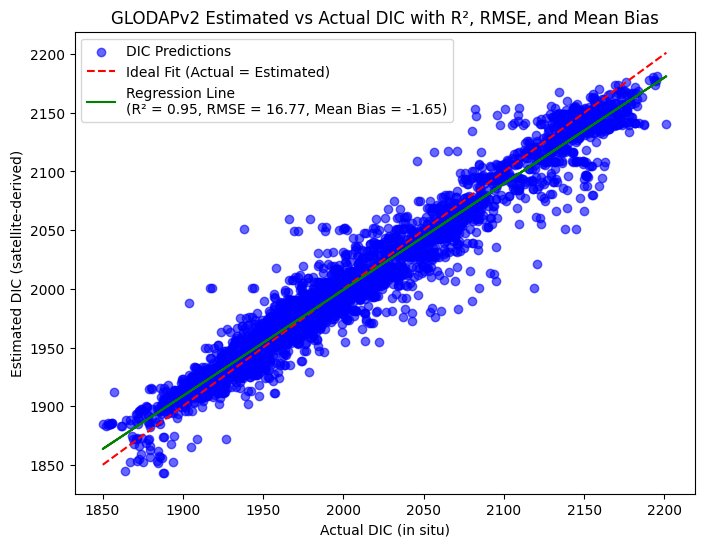

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='DIC Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})')

# Labels and title
plt.xlabel('Actual DIC (in situ)')
plt.ylabel('Estimated DIC (satellite-derived)')
plt.title('GLODAPv2 Estimated vs Actual DIC with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

In [ ]:
HOT_satellite = satellite_data[(satellite_data['latitude'] == 22.875) & (satellite_data['longitude'] == 202.125)]
HOT_satellite

,latitude,longitude,month,sst,chlor_a,sss,poc,pic,u_wind,v_wind
97537200,22.875,202.125,0,26.305000,0.057464,35.142174,34.399902,0.000092,-5.552091,-7.309467e-01
97537201,22.875,202.125,1,25.760000,0.102148,35.223442,40.199707,0.000024,-7.389859,-3.872861e-01
97537202,22.875,202.125,2,25.180000,0.106645,35.240566,39.600098,0.000020,-8.923004,-1.174736e+00
97537203,22.875,202.125,3,23.725000,0.123680,35.144848,41.000000,0.000020,-8.998958,-1.912788e+00
97537204,22.875,202.125,4,23.535000,0.086657,35.226425,36.199707,0.000016,-5.129163,4.153514e+00
...,...,...,...,...,...,...,...,...,...,...
97537345,22.875,202.125,145,27.289999,0.060268,35.054450,33.799805,0.000092,-5.200000,-9.552245e-16
97537346,22.875,202.125,146,26.234999,0.072551,35.126274,35.399902,0.000038,-8.197190,-2.146510e-01
97537347,22.875,202.125,147,24.824999,0.094533,35.101986,38.399902,0.000036,-7.352603,-2.603693e+00
97537348,22.875,202.125,148,23.670000,0.080072,35.100357,35.199707,0.000054,4.383082,5.712144e+00


In [ ]:
HOTdata = """
2350200222, 092711, 010815,    5.8,  1991.5,  8.087,    -9,
2360200722, 110511, 095852,    5.7,  1989.4,  8.082,  2315,
2370200422, 112911, 084830,    6.0,  1996.1,  8.077,  2318,
2380200622, 122011, 061318,    5.0,  2005.5,  8.071,  2325,
2390200722, 011912, 065446,    5.5,  2007.7,  8.062,  2326,
2400200422, 032512, 183439,    6.4,  2008.6,  8.059,  2322,
2410201223, 050312, 215925,    5.9,  2008.9,  8.055,  2318,
2420201322, 060112, 041458,    4.9,  2005.0,  8.063,  2316,
2430200822, 062712, 162419,    5.7,  2013.1,  8.059,  2325,
2440200722, 080112, 065902,   10.5,  2007.7,  8.065,  2318,
2450200622, 081812, 065730,    4.9,  1999.6,  8.064,  2307,
2460200622, 091512, 070559,    5.7,  1997.8,  8.066,  2307,
2470200622, 100812, 074841,    4.5,  2000.1,  8.066,  2316,
2480200622, 120412, 083046,    7.0,  2015.4,  8.068,  2334,
2490200622, 021313, 071338,    7.3,  2019.5,  8.055,  2331,
2500200722, 030713, 071737,    8.7,  2024.5,  8.050,  2333,
2510200622, 040613, 071006,    5.3,  2029.0,  8.048,  2337,
2520200722, 051813, 071938,    8.8,  1995.5,  8.059,  2301,
2530200722, 062613, 071750,    7.2,  2007.8,  8.063,  2321,
2540200622, 091213, 070930,    7.4,  2009.3,  8.082,  2336,
2550200622, 100213, 070152,    7.5,    -9.0,  8.081,  2323,
2560200622, 102813, 070946,    6.5,  1999.0,  8.081,  2323,
2570200623, 112713, 072318,    6.0,  2008.8,  8.081,  2338,
2580200623, 122113, 071840,    6.7,  2007.8,  8.089,  2336,
2590200623, 011614, 073433,    6.5,  2017.9,  8.068,  2335,
2600200623, 021514, 091648,    6.2,  2018.1,  8.061,  2336,
2610200623, 030614, 071457,    7.5,  2003.4,  8.066,  2321,
2620200623, 041114, 070940,    4.9,  2013.5,  8.064,  2328,
2630200523, 060114, 070217,    4.8,  2003.5,  8.070,  2326,
2640200623, 070114, 071958,    5.3,  2003.2,  8.074,  2323,
2650200623, 091514, 071751,    5.3,  1981.0,  8.083,  2300,
2660200623, 101414, 071924,    5.6,  1979.4,  8.089,  2308,
2670200623, 112214, 071138,    5.0,  1995.9,  8.092,  2325,
2680200623, 121714, 103137,    7.8,  2007.9,  8.073,  2327,
2690200623, 022515, 073446,    4.8,  2005.0,  8.061,  2320,
2700200623, 033015, 125737,    4.5,  2013.4,  8.061,  2325,
2710200622, 042215, 082405,    6.0,  1997.1,  8.067,  2318,
2720200722, 052415, 070942,    4.4,  2006.3,  8.069,  2324,
2730200722, 062015, 072322,    6.4,  1995.2,  8.074,  2310,
2740200722, 072015, 070452,    6.1,  1995.5,  8.075,  2313,
2750200622, 081315, 070720,    4.6,  2001.8,  8.079,  2331,
2770200622, 101415, 065216,    5.7,  1996.8,  8.077,  2320,
2780200522, 111415, 072027,    4.8,  1994.4,  8.084,  2320,
2790200622, 120915, 070430,    4.9,  1982.9,  8.085,  2307,
2800200622, 011316, 071341,    7.9,  1982.8,  8.078,  2305,
2810200622, 021016, 074645,    6.0,  1990.9,  8.076,  2310,
2820200722, 030916, 144214,    6.5,  1995.7,  8.075,  2314,
2830200622, 041516, 071607,    4.9,  1986.7,  8.067,  2299,
2840200422, 052916, 070401,    4.4,  1985.1,  8.073,  2303,
2850200622, 071216, 072610,    7.1,  1985.6,  8.073,  2300,
2860200522, 081016, 070131,    5.2,  1982.2,  8.076,  2301,
2870200622, 101616, 073924,    5.6,  1986.3,  8.078,  2305,
2880200522, 112716, 070233,    6.5,  1996.5,  8.074,  2312,
2890200522, 012417, 083436,    5.2,  2003.0,  8.058,  2307,
2900200124, 022217, 222247,    5.0,    -9.0,  8.064,    -9,
2900200522, 022317, 102623,    5.8,  1994.7,  8.059,  2300,
2900200717, 022317, 164104,    6.0,    -9.0,  8.063,    -9,
2900200916, 022417, 005249,    5.5,    -9.0,  8.064,    -9,
2910200324, 032817, 200346,    5.7,    -9.0,  8.064,    -9,
2910200722, 032917, 114147,    5.9,  1991.5,  8.066,  2304,
2910201524, 033017, 124929,    5.3,    -9.0,  8.067,    -9,
2920200622, 042617, 072147,    4.7,  1987.2,  8.064,  2299,
2930200224, 052317, 195747,    5.3,    -9.0,  8.068,    -9,
2930200622, 052417, 075330,    5.8,  1985.3,  8.069,  2299,
2930201104, 052417, 220236,    5.4,    -9.0,  8.070,    -9,
2940200622, 062117, 080236,    7.7,  1975.9,  8.078,  2287,
2950200622, 080917, 070156,    5.2,  1978.3,  8.084,  2299,
2960200522, 100717, 074107,    7.3,  1987.8,  8.084,  2310,
2970200622, 110917, 071723,    4.6,  1988.3,  8.079,  2312,
2980200622, 121317, 071715,    5.8,  1999.6,  8.067,  2315,
3000200622, 022618, 073916,    6.5,  2000.8,  8.056,  2308,
3010200422, 041818, 071306,    4.8,  2007.5,  8.045,  2315,
3020200522, 051618, 070438,    5.4,  1988.4,  8.057,  2299,
3030200522, 062718, 072316,    7.1,  1978.6,  8.066,  2292,
3040200622, 072518, 071055,    5.6,  1986.4,  8.067,  2303,
3050200622, 091118, 072037,    5.7,  1965.0,  8.079,  2272,
3060200622, 101318, 082323,    5.2,  1987.4, -9.000,  2305,
3070200622, 111718, 085130,    6.1,  2000.1,  8.060,  2318,
3090200622, 011619, 082552,    4.6,  1988.8,  8.069,  2298,
3100200322, 022019, 085017,    7.5,  1994.9,  8.056,  2296,
3110200622, 050319, 073153,    5.7,  1991.6,  8.054,  2292,
3120200622, 061219, 073149,    5.2,  1984.1,  8.062,  2290,
3130200622, 070219, 071741,    4.1,  1966.3,  8.075,  2275,
3140200622, 080319, 071825,    5.5,  1969.4,  8.075,  2276,
3150200622, 090519, 072556,    5.5,  1967.2,  8.084,  2281,
3160200522, 101819, 070131,    5.2,  1979.0,  8.086,  2303,
3170200622, 122019, 073624,    5.4,  1977.0,  8.073,  2287,
3180200322, 010820, 060053,    6.5,  1976.4,  8.074,  2291,
3190200622, 013120, 100443,    7.1,  1984.8,  8.064,  2288,
3200200722, 071620, 070834,    4.9,  1965.8,  8.072,  2275,
3210200122, 080720, 125611,    4.6,  1967.5, -9.000,    -9,
3210200822, 080920, 070008,    4.8,  1962.8,  8.082,  2277,
3220200322, 090220, 130825,    4.7,  1964.8, -9.000,    -9,
3220201022, 090420, 072002,    5.0,  1970.2,  8.084,  2288,
3230200122, 092620, 131936,    4.2,  1966.9, -9.000,    -9,
3230200722, 092820, 070340,    4.7,  1965.7,  8.078,  2282,
3240200122, 111820, 125259,    4.3,  1974.5, -9.000,    -9,
3240200822, 112020, 073121,    5.6,  1973.1,  8.077,  2293,
3250200121, 121820, 125700,    5.5,  1980.5, -9.000,    -9,
3250200622, 121920, 071458,    4.8,  1980.7,  8.066,  2296,
3260200122, 011221, 124813,    4.4,  1989.6, -9.000,    -9,
3260200622, 011321, 070406,    4.9,  1990.7,  8.069,  2306,
3270200122, 021621, 124413,    4.5,  1973.8, -9.000,    -9,
3270200622, 021721, 070705,    4.1,  1983.7,  8.059,  2287,
3280200122, 032321, 131956,    5.4,  1997.4, -9.000,    -9,
3280200522, 032421, 072336,    5.3,  1998.2,  8.049,  2298,
3290200622, 041421, 070729,    4.7,  1993.2,  8.051,    -9,
3300200122, 051621, 130258,    4.5,  1988.5, -9.000,    -9,
3300200622, 051721, 065825,    4.3,  1988.6,  8.051,  2286,
3310200122, 062221, 125705,    7.0,  1985.1, -9.000,    -9,
3310200622, 062321, 070601,    5.3,  1985.2,  8.056,  2288,
3320200522, 071721, 071403,    7.8,  1989.9,  8.061,  2290,
3320200722, 071721, 125707,    5.1,  1983.1, -9.000,    -9,
3330200522, 102921, 130727,    6.7,  2010.6, -9.000,    -9,
3330200922, 103021, 071503,    4.7,  2005.4,  8.064,  2317,
3340200823, 120721, 042222,    6.1,  1972.0,  8.051,  2272,
3350200622, 032822, 072012,    4.6,  2005.4,  8.053,  2308,
3360200622, 052722, 074602,    3.9,  1996.5,  8.046,  2290,
3370200622, 071022, 072543,    4.1,  2017.0,  8.052,  2328,
3380200622, 073122, 073712,    4.2,  2016.9,  8.053,  2324,
3390200722, 090222, 080909,    5.0,  1995.7,  8.063,  2304,
3400200522, 012523, 055232,    4.5,  1999.6,  8.055,  2303,
3410200822, 033123, 083318,    3.3,  2009.9,  8.044,  2303,
3420200822, 052723, 075358,    4.0,  1999.3,  8.035,  2288,
3430200622, 081123, 070649,    4.3,  2002.6,  8.050,  2304,
3440200723, 091623, 211537,    4.3,  2001.7,  8.065,  2312,
3450200422, 100923, 105436,    5.4,  1992.3, -9.000,  2304,
3460200622, 110623, 070716,    5.4,  1999.0,  8.066,  2308,
3470200722, 112923, 072458,    5.1,  2005.8,  8.055,  2308,
3480200622, 122923, 072419,    5.9,  2013.1,  8.043,  2311"""

In [ ]:
from io import StringIO
column_names = ["ID", "Date", "Time", "Pressure", "DIC", "pH", "Alkalinity"]
dtype_dict = {
    "ID": str,
    "Date": str,
    "Time": str
}
# Read the data into a DataFrame
HOT = pd.read_csv(StringIO(HOTdata), header=None, index_col=False, names=column_names, dtype=dtype_dict, skipinitialspace=True)

# Display the DataFrame
HOT

,ID,Date,Time,Pressure,DIC,pH,Alkalinity
0,2350200222,092711,010815,5.8,1991.5,8.087,-9
1,2360200722,110511,095852,5.7,1989.4,8.082,2315
2,2370200422,112911,084830,6.0,1996.1,8.077,2318
3,2380200622,122011,061318,5.0,2005.5,8.071,2325
4,2390200722,011912,065446,5.5,2007.7,8.062,2326
...,...,...,...,...,...,...,...
125,3440200723,091623,211537,4.3,2001.7,8.065,2312
126,3450200422,100923,105436,5.4,1992.3,-9.000,2304
127,3460200622,110623,070716,5.4,1999.0,8.066,2308
128,3470200722,112923,072458,5.1,2005.8,8.055,2308


In [ ]:
HOT['month'] = HOT['Date'].apply(lambda x: (2000 + int(x[4:6]) - 2011) * 12 + int(x[:2]) - 9)

In [ ]:
HOT['latitude'] = 22.875
HOT['longitude'] = 202.125

In [ ]:
HOT.replace(-9, np.nan, inplace=True)

In [ ]:
HOTDIC = HOT[['latitude', 'longitude', 'month', 'Pressure', 'DIC']]

In [ ]:
HOTDIC = HOTDIC.dropna()

In [ ]:
HOTDIC

,latitude,longitude,month,Pressure,DIC
0,22.875,202.125,0,5.8,1991.5
1,22.875,202.125,2,5.7,1989.4
2,22.875,202.125,2,6.0,1996.1
3,22.875,202.125,3,5.0,2005.5
4,22.875,202.125,4,5.5,2007.7
...,...,...,...,...,...
125,22.875,202.125,144,4.3,2001.7
126,22.875,202.125,145,5.4,1992.3
127,22.875,202.125,146,5.4,1999.0
128,22.875,202.125,146,5.1,2005.8


In [ ]:
HOTDICMatchup = pd.merge(HOTDIC, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
HOTDICMatchup['windspeed'] = np.sqrt(HOTDICMatchup['u_wind'] ** 2 + HOTDICMatchup['v_wind'] ** 2)
HOTDICMatchup['winddir'] = (np.degrees(np.arctan2(HOTDICMatchup['u_wind'] + 1e-5, HOTDICMatchup['u_wind'] + 1e-5)) + 360) % 360
HOTDICMatchup

,latitude,longitude,month,Pressure,DIC,sst,chlor_a,sss,poc,pic,u_wind,v_wind,windspeed,winddir
0,22.875,202.125,0,5.8,1991.5,26.305000,0.057464,35.142174,34.399902,0.000092,-5.552091,-7.309467e-01,5.6,225.0
1,22.875,202.125,2,5.7,1989.4,25.180000,0.106645,35.240566,39.600098,0.000020,-8.923004,-1.174736e+00,9.0,225.0
2,22.875,202.125,2,6.0,1996.1,25.180000,0.106645,35.240566,39.600098,0.000020,-8.923004,-1.174736e+00,9.0,225.0
3,22.875,202.125,3,5.0,2005.5,23.725000,0.123680,35.144848,41.000000,0.000020,-8.998958,-1.912788e+00,9.2,225.0
4,22.875,202.125,4,5.5,2007.7,23.535000,0.086657,35.226425,36.199707,0.000016,-5.129163,4.153514e+00,6.6,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,22.875,202.125,144,4.3,2001.7,26.824999,0.058803,34.951560,34.600098,0.000086,-7.789311,-4.082205e-01,7.8,225.0
118,22.875,202.125,145,5.4,1992.3,27.289999,0.060268,35.054450,33.799805,0.000092,-5.200000,-9.552245e-16,5.2,225.0
119,22.875,202.125,146,5.4,1999.0,26.234999,0.072551,35.126274,35.399902,0.000038,-8.197190,-2.146510e-01,8.2,225.0
120,22.875,202.125,146,5.1,2005.8,26.234999,0.072551,35.126274,35.399902,0.000038,-8.197190,-2.146510e-01,8.2,225.0


In [ ]:
HOTDICMatchup = HOTDICMatchup.loc[HOTDICMatchup.groupby('month')['Pressure'].idxmin()]

In [ ]:
X = HOTDICMatchup[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y = HOTDICMatchup['DIC']

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(130.55903194395736, 0.3161979797971669, 3.3651852053952083)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
y.reset_index(drop=True, inplace=True)

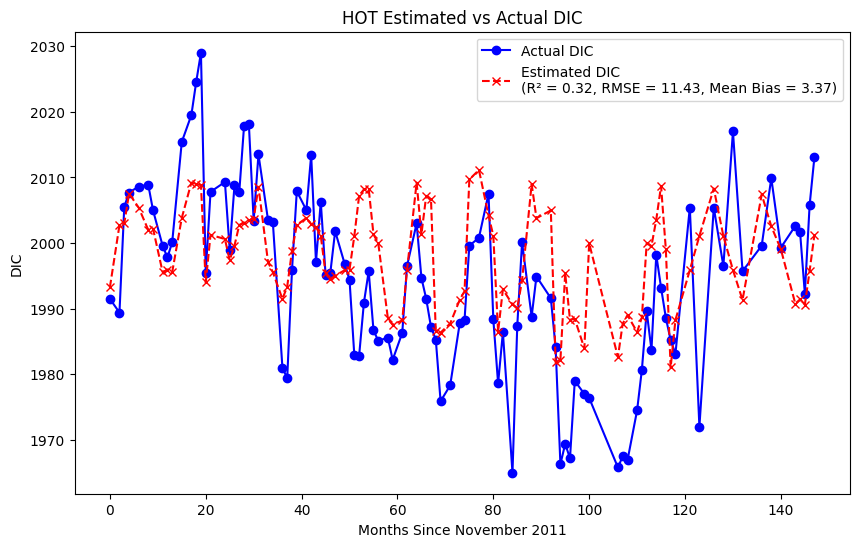

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred and y are defined as numpy arrays or lists of predicted and actual values
# If they are pandas series, you can directly use them as well.

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(HOTDICMatchup['month'], y, label='Actual DIC', marker='o', linestyle='-', color='b')
plt.plot(HOTDICMatchup['month'], y_pred, label=f'Estimated DIC \n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})', marker='x', linestyle='--', color='r')

# Adding title and labels
plt.title('HOT Estimated vs Actual DIC')
plt.xlabel('Months Since November 2011')
plt.ylabel('DIC')

# Show legend
plt.legend()

# Show plot
plt.show()

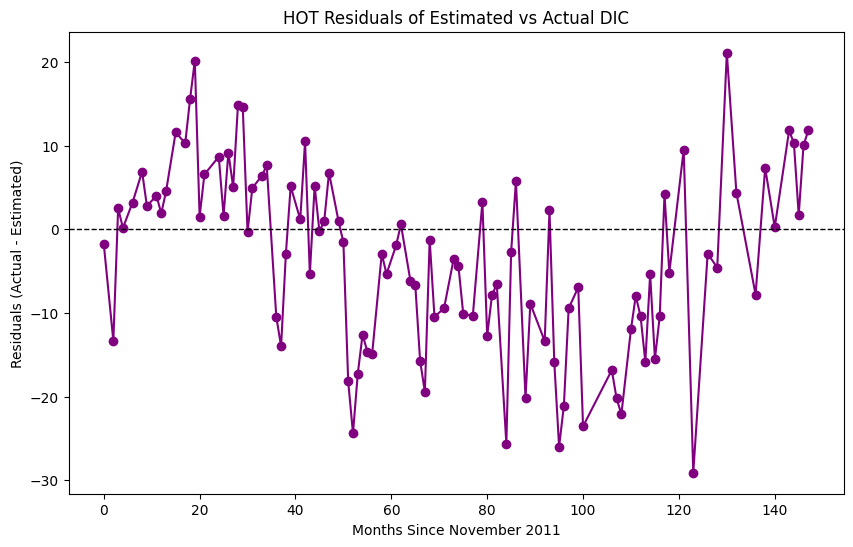

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y and y_pred are defined as numpy arrays, lists, or pandas Series
# Calculate residuals
residuals = y - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(HOTDICMatchup['month'], residuals, marker='o', linestyle='-', color='purple')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Adding title and labels
plt.title('HOT Residuals of Estimated vs Actual DIC')
plt.xlabel('Months Since November 2011')
plt.ylabel('Residuals (Actual - Estimated)')

# Show plot
plt.show()

In [ ]:
dtype_dict = {
    "ID": str,
    "yyyymmdd": str,
}
BATS = pd.read_csv('/content/drive/MyDrive/STS/STSData/bats_bottle.txt', delim_whitespace=True, index_col=False, dtype=dtype_dict)

<ipython-input-39-4005f47a7d05>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  BATS = pd.read_csv('/content/drive/MyDrive/STS/STSData/bats_bottle.txt', delim_whitespace=True, index_col=False, dtype=dtype_dict)


In [ ]:
BATS

,Id,yyyymmdd,decy,time,latN,lonW,QF,Depth,Temp,CTD_S,...,Bact,POP,TDP,SRP,BSi,LSi,Pro,Syn,Piceu,Naneu
0,1000100112,19881020,1988.80311,2230,31.783,64.116,2,2000.5,3.817,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
1,1000100111,19881020,1988.80311,2230,31.783,64.116,2,2200.3,3.577,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
2,1000100110,19881020,1988.80311,2230,31.783,64.116,2,2398.9,3.317,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
3,1000100109,19881020,1988.80311,2230,31.783,64.116,2,2600.0,3.127,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
4,1000100108,19881020,1988.80311,2230,31.783,64.116,2,2801.7,2.927,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69971,1040502020,20230624,2023.47789,1017,31.800,64.744,2,201.1,19.231,36.638,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69972,1040502021,20230624,2023.47789,1017,31.800,64.744,2,251.4,19.112,36.639,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69973,1040502022,20230624,2023.47789,1017,31.800,64.744,2,300.8,18.917,36.632,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69974,1040502023,20230624,2023.47789,1017,31.800,64.744,2,403.4,18.536,36.584,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999


In [ ]:
BATS = BATS[['yyyymmdd', 'latN', 'lonW', 'Depth', 'CO2']]
BATS.replace(-999, np.nan, inplace=True)
BATS = BATS.dropna()
BATS['lonW'] = 360 - BATS['lonW']
BATS = BATS.rename(columns={'lonW' : 'longitude', 'latN' : 'latitude'})
BATS['longitude'] = round((BATS['longitude']) / 0.25) * 0.25 + 0.125
BATS['latitude'] = round((BATS['latitude']) / 0.25) * 0.25 + 0.125
BATS['month'] = BATS['yyyymmdd'].apply(lambda x: (int(x[:4]) - 2011) * 12 + int(x[4:6]) - 9)
BATS = BATS[BATS['month'] >= 0]

<ipython-input-41-f3287c2847b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BATS.replace(-999, np.nan, inplace=True)


In [ ]:
BATS

,yyyymmdd,latitude,longitude,Depth,CO2,month
40376,20120130,31.875,295.875,5.6,2064.2,4
40378,20120130,31.875,295.875,10.9,2065.8,4
40380,20120130,31.875,295.875,18.6,2067.2,4
40382,20120130,31.875,295.875,40.0,2068.6,4
40384,20120130,31.875,295.875,60.4,2070.5,4
...,...,...,...,...,...,...
69855,20230622,31.875,295.875,599.6,2157.7,141
69858,20230622,31.875,295.875,699.5,2174.0,141
69861,20230622,31.875,295.875,799.6,2186.9,141
69864,20230622,31.875,295.875,900.1,2190.8,141


In [ ]:
BATSDICMatchup = pd.merge(BATS, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
BATSDICMatchup = BATSDICMatchup.loc[BATSDICMatchup.groupby(['month', 'latitude', 'longitude'])['Depth'].idxmin()]
BATSDICMatchup = BATSDICMatchup[BATSDICMatchup['Depth'] <= 30]

In [ ]:
BATSDICMatchup = BATSDICMatchup[(BATSDICMatchup['latitude'] == 31.875) & (BATSDICMatchup['longitude'] == 295.875)]
BATSDICMatchup['windspeed'] = np.sqrt(BATSDICMatchup['u_wind'] ** 2 + BATSDICMatchup['v_wind'] ** 2)
BATSDICMatchup['winddir'] = (np.degrees(np.arctan2(BATSDICMatchup['u_wind'] + 1e-5, BATSDICMatchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
BATSDICMatchup = BATSDICMatchup[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir', 'CO2', 'month']]
BATSDICMatchup = BATSDICMatchup.dropna()
X = BATSDICMatchup[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']].reset_index(drop=True)
y = BATSDICMatchup['CO2'].reset_index(drop=True)

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(116.42278043822549, 0.6009558243895264, -4.292087472207342)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


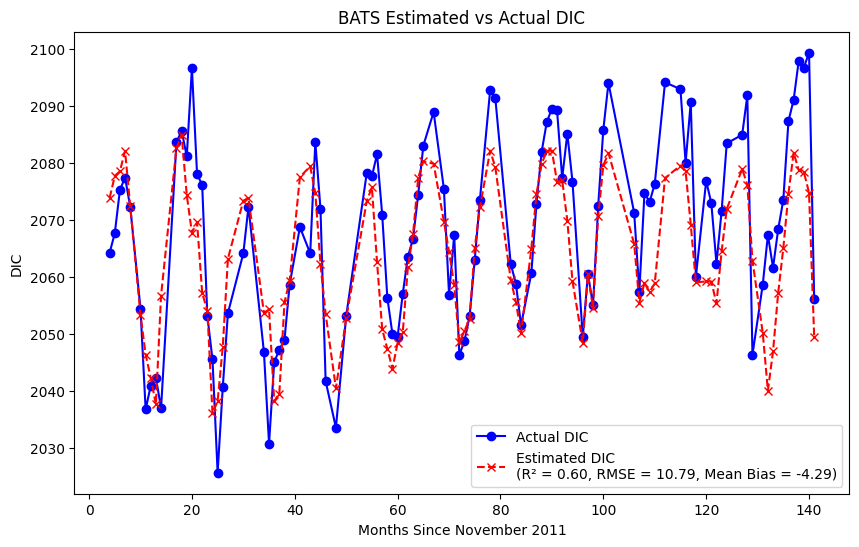

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred and y are defined as numpy arrays or lists of predicted and actual values
# If they are pandas series, you can directly use them as well.

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(BATSDICMatchup['month'], y, label='Actual DIC', marker='o', linestyle='-', color='b')
plt.plot(BATSDICMatchup['month'], y_pred, label=f'Estimated DIC\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})', marker='x', linestyle='--', color='r')

# Adding title and labels
plt.title('BATS Estimated vs Actual DIC')
plt.xlabel('Months Since November 2011')
plt.ylabel('DIC')

# Show legend
plt.legend()

# Show plot
plt.show()

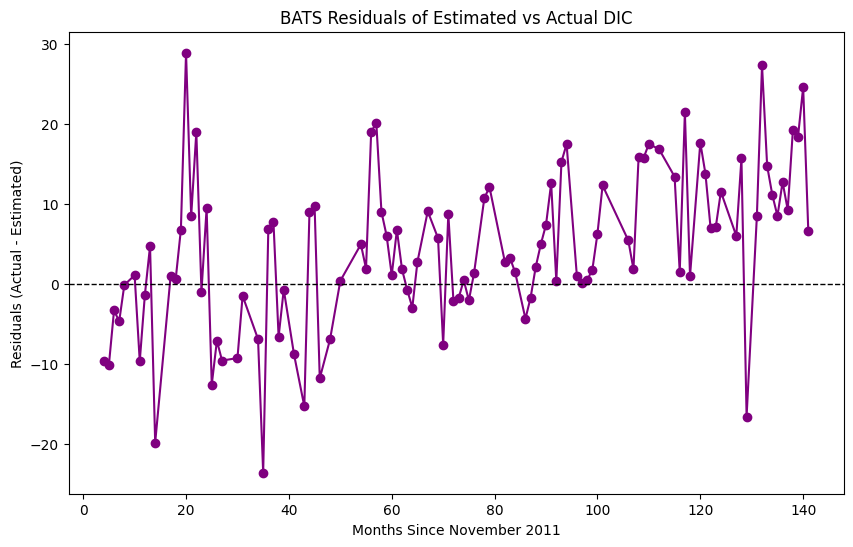

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y and y_pred are defined as numpy arrays, lists, or pandas Series
# Calculate residuals
residuals = y - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(BATSDICMatchup['month'], residuals, marker='o', linestyle='-', color='purple')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Adding title and labels
plt.title('BATS Residuals of Estimated vs Actual DIC')
plt.xlabel('Months Since November 2011')
plt.ylabel('Residuals (Actual - Estimated)')

# Show plot
plt.show()

## Basin Analysis

In [14]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/output_basins.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
basins = xr_dataset.to_dataframe().reset_index()

In [15]:
basins = basins.rename(columns={'lon' : 'longitude', 'lat' : 'latitude'})

In [16]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y = test[['tco2', 'latitude', 'longitude']]

In [17]:
!pip install joblib

In [18]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_dic.joblib')

In [19]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.4s finished


In [20]:
y['predictions'] = y_pred

<ipython-input-20-e35c45553dfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [21]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [22]:
def region_accuracy(rgn = -1):
  if rgn != -1:
    merged_df = pd.merge(y, basins, on=['latitude', 'longitude'])
    basin_data = merged_df[merged_df['open_ocean'] == rgn]
  else:
    basin_data = y
  rmse = np.sqrt(mean_squared_error(basin_data['tco2'], basin_data['predictions']))
  r2 = r2_score(basin_data['tco2'], basin_data['predictions'])
  mean_bias = np.mean(basin_data['predictions'] - basin_data['tco2'])
  return rmse, r2, mean_bias, len(basin_data)

In [23]:
print("RMSE, R2, Bias, n")
print("Atlantic: ", region_accuracy(1))
print("Pacific: ", region_accuracy(2))
print("Indian: ", region_accuracy(3))
print("Arctic: ", region_accuracy(4))
print("Southern: ", region_accuracy(5))
print("Global: ", region_accuracy())

RMSE, R2, Bias, n
Atlantic:  (14.79115994846039, 0.9211964453030926, -8.09092142163527, 2213652)
Pacific:  (13.715929750304781, 0.9353844183713691, -8.00046019186724, 4768592)
Indian:  (13.466815359999499, 0.945943498146653, -7.806418876225425, 1396298)
Arctic:  (27.11731280730884, 0.9402255640749272, -3.827913208004506, 156379)
Southern:  (9.627824359233832, 0.9363065273558007, -5.579873661254627, 2019811)
Global:  (13.635012935404847, 0.9671804741309464, -7.451181333684216, 10598925)


## Monthly Analysis

In [24]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y = test[['tco2', 'month']]

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_dic.joblib')

In [25]:
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.3s finished
<ipython-input-25-cdc18176f924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [26]:
def month_accuracy(mn):
  mn = (mn + 4) % 12
  month_data = y[y['month'] % 12 == mn]
  rmse = np.sqrt(mean_squared_error(month_data['tco2'], month_data['predictions']))
  r2 = r2_score(month_data['tco2'], month_data['predictions'])
  mean_bias = np.mean(month_data['predictions'] - month_data['tco2'])
  return rmse, r2, mean_bias, len(month_data)

In [27]:
print("RMSE, R2, Bias, n")
print("January: ", month_accuracy(0))
print("February: ", month_accuracy(1))
print("March: ", month_accuracy(2))
print("April: ", month_accuracy(3))
print("May: ", month_accuracy(4))
print("June: ", month_accuracy(5))
print("July: ", month_accuracy(6))
print("August: ", month_accuracy(7))
print("September: ", month_accuracy(8))
print("October: ", month_accuracy(9))
print("November: ", month_accuracy(10))
print("December: ", month_accuracy(11))

RMSE, R2, Bias, n
January:  (12.308818783578106, 0.9714802870684137, -6.444821103644555, 953842)
February:  (11.868376259405546, 0.9737932209664746, -6.65817511296946, 974285)
March:  (12.041598192296131, 0.9747379611973451, -7.570071116189333, 979134)
April:  (13.289027441231445, 0.9651856035611804, -7.22213208471261, 814897)
May:  (14.009263550497657, 0.9613164010091304, -6.577824367956123, 804883)
June:  (15.19844575445422, 0.9548750731906226, -7.540718037296614, 756954)
July:  (15.99225807974417, 0.9530102957982647, -8.388285825696375, 787782)
August:  (14.420726609166556, 0.9655089828053797, -7.789656167562168, 868005)
September:  (14.35852632894886, 0.9670924222994105, -7.2909014653993305, 915887)
October:  (13.322607958938782, 0.9705188115879604, -7.663524879029966, 935118)
November:  (13.31257657190441, 0.968727022276933, -7.88767318928726, 905683)
December:  (13.835029934326633, 0.964395318284953, -8.513635495330988, 902455)


In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
satellite_data['mn'] = satellite_data['month'] % 12
satellite_data['cmon'] = np.cos(np.deg2rad(satellite_data['mn']))
satellite_data['smon'] = np.sin(np.deg2rad(satellite_data['mn']))
satellite_data['clon'] = np.cos(np.deg2rad(satellite_data['longitude']))
satellite_data['slon'] = np.sin(np.deg2rad(satellite_data['longitude']))
satellite_data['pic/poc'] = satellite_data['pic']/satellite_data['poc']
satellite_data['logchla'] = np.log(satellite_data['chlor_a'] + 1e-5)
satellite_data['windspeed'] = np.sqrt(satellite_data['u_wind'] ** 2 + satellite_data['v_wind'] ** 2)
satellite_data['winddir'] = (np.degrees(np.arctan2(satellite_data['u_wind'] + 1e-5, satellite_data['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
y = satellite_data[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir', 'month']]
y = y.dropna()
X = y[['latitude', 'sst', 'sss', 'longitude', 'windspeed', 'winddir']]
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   23.2s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   46.6s finished


In [ ]:
import xarray as xr
import numpy as np

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

tco2 = ds['dic']

# Select the specific variable 'tco2' and time indices from 361 to 480
tco2_subset = tco2.isel(time=slice(360, 480))  # Python uses zero-based indexing

# Compute the monthly climatology over the selected 10 years
monthly_climatology = tco2_subset.groupby('time.month').mean(dim='time')

monthly_climatology = monthly_climatology.assign_coords(
    lon=((monthly_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
monthly_climatology = monthly_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the monthly climatologies onto the new grid
interp_tco2 = monthly_climatology.interp(lat=new_lat, lon=new_lon, method='linear')

In [ ]:
ten_year = y[(y['month'] >= 4) & (y['month'] <= 123)]

In [ ]:
def month_clim(mn = -1):
  if(mn != -1):
    mn = (mn + 4) % 12
    month_data = ten_year[ten_year['month'] % 12 == mn]
  else:
    month_data = ten_year
  month_data = month_data.dropna()
  monthly_climatology = month_data.groupby(['latitude', 'longitude'])['predictions'].mean().reset_index()
  return monthly_climatology

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'interp_tco2' is your observed climatology DataArray from previous steps
# And 'month_clim' is your function that returns predicted climatology for a given month

# Initialize lists to store metrics for each month
r2_list = []
rmse_list = []
mean_bias_list = []
n_list = []

for i in range(12):
    # **1. Get Predicted Climatology for Month i**
    # Call your function 'month_clim' to get the predicted climatology for month i
    pred_clim = month_clim(i)  # Should return a pandas DataFrame

    # Ensure 'pred_clim' has columns 'lat', 'lon', 'tco2_pred'
    if 'predictions' in pred_clim.columns:
        pred_clim = pred_clim.rename(columns={'predictions': 'tco2_pred'})


    # **3. Get Observed Climatology for Month i+1**
    # 'interp_tco2' uses months from 1 to 12
    observed_clim = interp_tco2.sel(month=i+1)

    # Convert the observed DataArray to a DataFrame
    observed_clim_df = observed_clim.to_dataframe(name='tco2_obs').reset_index().dropna()
    observed_clim_df = observed_clim_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
    observed_clim_df['longitude'] = (observed_clim_df['longitude'] + 360) % 360

    # **4. Merge Predicted and Observed DataFrames on 'lat' and 'lon'**
    merged_df = pd.merge(pred_clim, observed_clim_df, on=['latitude', 'longitude'])

    merged_df = merged_df.dropna()
    # **5. Compute Metrics**
    # R² Score
    r2 = r2_score(merged_df['tco2_obs'], merged_df['tco2_pred'])

    # Root Mean Squared Error (rmse)
    rmse = np.sqrt(mean_squared_error(merged_df['tco2_obs'], merged_df['tco2_pred']))

    # Mean Bias (Mean of Differences)
    mean_bias = np.mean(merged_df['tco2_pred'] - merged_df['tco2_obs'])

    n = len(merged_df)

    # print(r2, rmse, mean_bias, n)
    # **6. Store Metrics**
    r2_list.append(r2)
    rmse_list.append(rmse)
    mean_bias_list.append(mean_bias)
    n_list.append(n)

# **7. Compile Results into a DataFrame**
metrics_df = pd.DataFrame({
    'Month': range(1, 13),
    'R²': r2_list,
    'rmse': rmse_list,
    'Mean Bias': mean_bias_list,
    'n': n_list
})

# **8. Display the Results**
print(metrics_df)

    Month        R²       rmse  Mean Bias       n
0       1  0.971087  12.746710  -1.571449  536469
1       2  0.974251  12.052854  -2.019284  543096
2       3  0.978671  11.217173  -1.932744  536458
3       4  0.976447  11.891128  -2.207026  523424
4       5  0.969658  13.132816  -1.577708  511018
5       6  0.952394  16.486309  -1.711261  506348
6       7  0.932446  22.533315  -0.538672  512772
7       8  0.927990  24.322534   0.959389  516456
8       9  0.936003  22.546184  -0.111672  518799
9      10  0.943717  20.242156  -1.516389  518007
10     11  0.967030  13.972368  -2.183344  506037
11     12  0.977035  11.566815  -1.955946  522985


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

# Select the specific variable 'tco2' and time indices from 361 to 480
tco2_subset = ds['dic'].isel(time=slice(360, 480))  # Zero-based indexing

# Compute the full climatology over the selected 10-year period
full_climatology = tco2_subset.mean(dim='time')

full_climatology = full_climatology.assign_coords(
    lon=((full_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
full_climatology = full_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the full climatology onto the new grid
interp_full_climatology = full_climatology.interp(lat=new_lat, lon=new_lon)

# Convert to DataFrame
full_climatology_df = interp_full_climatology.to_dataframe(name='tco2_obs').reset_index().dropna()
full_climatology_df = full_climatology_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
# full_climatology_df['longitude'] = (full_climatology_df['longitude'] + 360) % 360

In [ ]:
full_climatology_df.max()

,0
latitude,85.375000
longitude,359.375000
tco2_obs,2320.793976


In [ ]:
pred_clim = month_clim()
merged_df = pd.merge(pred_clim, full_climatology_df, on=['latitude', 'longitude']).dropna()
merged_df['DIC Differences With GRaCER'] = merged_df['predictions'] - merged_df['tco2_obs']

In [ ]:
ds = merged_df.set_index(['latitude', 'longitude']).to_xarray()
ds.to_netcdf('climatological_diff.nc')

In [ ]:
merged_df.min()

,0
latitude,-74.375000
longitude,0.625000
predictions,1064.332780
tco2_obs,1182.749975
DIC Differences With GRaCER,-316.473392
